# Home Credit Analysis:
    Erisha Aryanti
    erishaaryanti@gmail.com

#### Build machine learning model to accurately predict the clients to ensure the clients capable of repayment are not rejected.

**Assessment Parameter:** <br>
- Dataset Preparation (5%) <br>
- EDA for the dataset (10%) <br>
- The step how you find the best machine learning model (25%) <br>
- Explore More Code (20%) <br>
- Your final score at Kaggle. (40%) <br>



SOURCE: <br>
https://www.kaggle.com/c/home-credit-default-risk/data

Related Kaggle Adaptations: <br>
Introduction: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Introduction:-Home-Credit-Default-Risk-Competition <br>
Feature Engineering 1: https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering <br>
Featue Engineering 2: https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2

## Import Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, accuracy_score, roc_auc_score#, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler#, RobustScaler
from imblearn.over_sampling import SMOTE

# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint, uniform as sp_uniform

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# Memory management
import gc 

# 1. Data Preparation

## 1.1 Import and Convert Data Types

The dataset that would be used are relatively big. So we will convert several data types so the memory consumed will be smaller:

    'object' converted into 'category'
    'booleans' converted into 1 and 0
    'float64' converted into 'float32'
    'int64' converted into 'int32'

#### Function to convert data types:

In [21]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

#### [Train and Test Data]

In [22]:
train = pd.read_csv('application_train.csv')
train = convert_types(train, print_info=True)
train.head()

Original Memory Usage: 0.3 gb.
New Memory Usage: 0.17 gb.


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,True,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,False,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,False,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,False,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,False,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
test = pd.read_csv('application_test.csv')
test = convert_types(test, print_info=True)
test.head()

Original Memory Usage: 0.05 gb.
New Memory Usage: 0.03 gb.


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Since we will apply some feature engineering and data preprocessing, we can join train and test data.

In [24]:
df = train.merge(test, how='outer')
# df = df.sample(50000)
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,True,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,False,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,False,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,False,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,False,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
356251,456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
356252,456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
356253,456224,NaN,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [25]:
#Storing label into a variable, since we are going to impute the missing values in the future
label = df['TARGET']
df = df.drop(columns='TARGET') 

#### [Bureau data]

In [26]:
bureau = pd.read_csv('bureau.csv')
bureau = convert_types(bureau, print_info=True)
bureau.head()

Original Memory Usage: 0.23 gb.
New Memory Usage: 0.13 gb.


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


#### [Bureau Balance Data]

In [27]:
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau_balance = convert_types(bureau_balance, print_info=True)
bureau_balance.head()

Original Memory Usage: 0.66 gb.
New Memory Usage: 0.35 gb.


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


#### [Previous Application Data]
    previous_application (called previous):
    previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.

In [28]:
previous = pd.read_csv('previous_application.csv')
previous = convert_types(previous, print_info=True)
previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.18 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


#### [Monthly Cash Data]
    POS_CASH_BALANCE (called cash):
    monthly data about previous point of sale or cash loans clients have had with Home Credit.
    Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

In [29]:
cash = pd.read_csv('POS_CASH_balance.csv')
cash = convert_types(cash, print_info=True)
cash.head()

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.41 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


#### [Monthly Credit Data]
    credit_card_balance (called credit): monthly data about previous credit cards clients have had with Home Credit.
    Each row is one month of a credit card balance, and a single credit card can have many rows.

In [30]:
credit = pd.read_csv('credit_card_balance.csv')
credit = convert_types(credit, print_info = True)
credit.head()

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.42 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


#### [Installment Data]
    installments_payment (called installments):
    payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

In [31]:
installment = pd.read_csv('installments_payments.csv')
installment = convert_types(installment, print_info = True)
installment.head()

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.49 gb.


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [32]:
df.select_dtypes('object')

,CODE_GENDER,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,FLAG_DOCUMENT_3
0,M,Working,Single / not married,True,True,True,True,0,True
1,F,State servant,Married,True,True,True,True,0,True
2,M,Working,Single / not married,True,True,True,True,0,False
3,F,Working,Civil marriage,True,True,True,False,0,True
4,M,Working,Single / not married,True,True,True,False,0,False
...,...,...,...,...,...,...,...,...,...
356250,F,Working,Widow,True,True,True,1,False,False
356251,F,Commercial associate,Married,True,True,True,0,False,True
356252,F,Commercial associate,Married,True,True,True,1,False,True
356253,M,Commercial associate,Married,True,True,True,1,False,True


# 2. EDA

## 2.1 Descriptive Statistics

In [33]:
#Main dataset
df.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,356255.000000,356255.000000,3.562550e+05,3.562550e+05,356219.000000,3.559770e+05,356255.000000,356255.000000,356255.000000,356255.000000,...,356255.000000,356255.000000,356255.000000,356255.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000
mean,278128.000000,0.414316,1.701161e+05,5.877674e+05,27425.560657,5.280200e+05,0.020917,-16041.248841,64317.231413,-4983.593527,...,0.007231,0.000514,0.000438,0.000289,0.005808,0.006281,0.029995,0.231697,0.304399,1.911564
std,102842.104413,0.720378,2.235068e+05,3.986237e+05,14732.808190,3.660650e+05,0.013915,4358.803980,141705.532576,3526.968986,...,0.084726,0.022659,0.020921,0.017001,0.079736,0.104250,0.191374,0.855949,0.786915,1.865338
min,100001.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000253,-25229.000000,-17912.000000,-24672.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189064.500000,0.000000,1.125000e+05,2.700000e+05,16731.000000,2.340000e+05,0.010006,-19676.000000,-2781.000000,-7477.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278128.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,4.500000e+05,0.018850,-15755.000000,-1224.000000,-4502.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367191.500000,1.000000,2.025000e+05,7.975575e+05,34960.500000,6.750000e+05,0.028663,-12425.000000,-290.000000,-1995.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [34]:
#Bureau
bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105273e+02,-1.017359e+03,3.825358e+03,6.410406e-03,3.545773e+05,1.370818e+05,6.229781e+03,3.791263e+01,-5.937483e+02,1.571327e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.985500e+03,7.138443e+02,2.059873e+05,9.622391e-02,1.150277e+06,6.790749e+05,4.489666e+04,5.937519e+03,7.207473e+02,3.256556e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


In [35]:
#Bureau balance
bureau_balance.describe()

,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00


In [36]:
previous.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,774370.000000,5951.000000,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.00000,997149.000000
mean,1.923089e+06,2.783572e+05,1.594889e+04,1.749806e+05,1.960131e+05,6.699080e+03,2.275182e+05,1.248418e+01,0.079712,0.188360,0.773517,-8.806797e+02,3.139511e+02,1.605409e+01,340114.343750,13838.132812,33764.871094,76829.148438,82314.84375,0.332570
std,5.325980e+05,1.028148e+05,1.477695e+04,2.933005e+05,3.177837e+05,2.090572e+04,3.154605e+05,3.334028e+00,0.107919,0.087671,0.100879,7.790997e+02,7.127443e+03,1.454715e+01,88611.609375,72421.296875,106544.812500,150155.109375,152926.93750,0.471501
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,-0.000015,0.034781,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.00000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,0.000000,0.160716,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.00000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,0.051605,0.189122,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.00000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,0.108909,0.193330,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.00000,1.000000
max,2.845382e+06,4.562550e+05,4.180582e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000,1.000000,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.00000,1.000000


In [37]:
cash.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.751403e+01,1.036928e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.151579e+01,1.101344e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


In [38]:
credit.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.827686e+04,1.538080e+05,5.962299e+03,7.432263e+03,2.881647e+02,2.968840e+03,3.541778e+03,...,5.595036e+04,5.808502e+04,5.809459e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.080733e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.074641e+05,1.651457e+05,2.803397e+04,3.336682e+04,8.197021e+03,2.066321e+04,5.525350e+03,...,1.015177e+05,1.071769e+05,1.071802e+05,1.088881e+00,3.190347e+00,8.250048e-02,3.212287e+00,2.001166e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03


In [39]:
installment.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.024620e+03,-1.033598e+03,1.675076e+04,1.691504e+04
std,5.362029e+05,1.027183e+05,1.033389e+00,2.666407e+01,7.961519e+02,7.956160e+02,4.964295e+04,5.375981e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


## 2.2 Number of Unique Values

In [40]:
df.select_dtypes('object').apply(pd.Series.nunique, axis=0).sort_values(ascending=False)

NAME_INCOME_TYPE      8
NAME_FAMILY_STATUS    6
CODE_GENDER           3
FLAG_DOCUMENT_3       2
FLAG_EMAIL            2
FLAG_PHONE            2
FLAG_CONT_MOBILE      2
FLAG_EMP_PHONE        2
FLAG_MOBIL            2
dtype: int64

## 2.3 Correlation

In [41]:
correlations = train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


## 2.3 Days Birth and Days Employee

#### Days Birth

'DAYS_BIRTH' feature is still in day unit and in negative values. We will transform it into year unit by dividing it with -365

In [42]:
df['DAYS_BIRTH'] = df['DAYS_BIRTH'] / -365
df['DAYS_BIRTH'].describe()

count    356255.000000
mean         43.948627
std          11.941929
min          20.104110
25%          34.041096
50%          43.164384
75%          53.906849
max          69.120548
Name: DAYS_BIRTH, dtype: float64

For visualization, we will convert the 'DAYS_BIRTH' 

In [43]:
train['DAYS_BIRTH'] = train['DAYS_BIRTH'] / -365
train['DAYS_BIRTH'].describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

#### Days Employed

For DAYS_EMPLOYED feature, the values are mostly in negative values and weirdly has many 365243 values. If 365423 is converted into year unit (365423/365) it return +-1000 years. So this anomalous values will be replaced with the feature's meadian value.

In [44]:
#Replacing outlier data with median value
df["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
df["DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].fillna(df['DAYS_EMPLOYED'].median())

#Convert into year unit
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'] / -365

## 2.2 KDE Plot

From the correlation result, we will do KDE plot for some most target correlated features: 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'

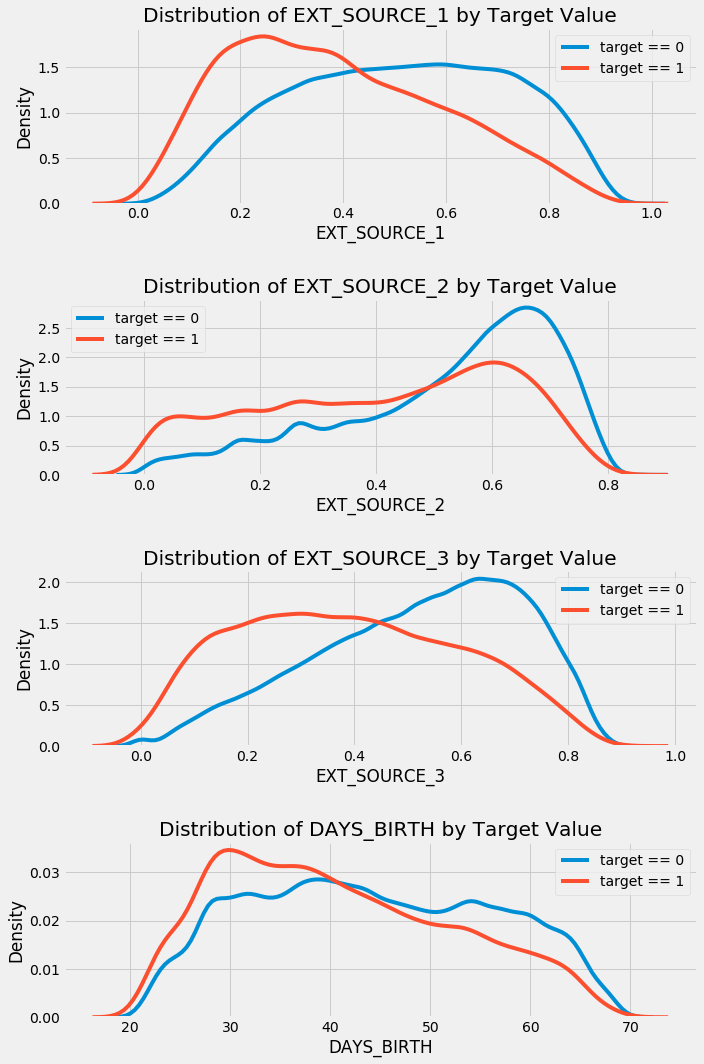

In [45]:
plt.figure(figsize = (10, 15))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

## 3. Missing and Duplicate Values

## 3.1 Remove Missing Values

#### Missing Values Quick Look

In [46]:
# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("From " + str(df.shape[1]) + " columns, there are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.\n")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [47]:
dataset = [df, bureau, bureau_balance, previous, cash, credit, installment]
dfname = ['Main Dataset', 'Bureau', 'Bureau Balance', 'Previous', 'Monthly Cash', 'Credit', 'Installment']

for i in enumerate(dataset):
    print(dfname[i[0]])
    missing_values_table(i[1])

Main Dataset
From 121 columns, there are 67 columns that have missing values.

Bureau
From 17 columns, there are 7 columns that have missing values.

Bureau Balance
From 3 columns, there are 0 columns that have missing values.

Previous
From 37 columns, there are 16 columns that have missing values.

Monthly Cash
From 8 columns, there are 2 columns that have missing values.

Credit
From 23 columns, there are 9 columns that have missing values.

Installment
From 8 columns, there are 2 columns that have missing values.



#### Remove Missing Values

Columns with missing values more than 40% will be dropped.

In [48]:
thresh = 40

#MAIN DATA
df_miss = pd.DataFrame(df.isnull().sum())
df_miss['percent'] = 100 * df_miss[0] / len(df)
missing_columns = list(df_miss.index[df_miss['percent'] > thresh]) # list of missing columns
df = df.drop(columns = missing_columns) # Drop the missing columns and return
print('Main Data Final Shape: ', df.shape)

#BUREAU
df_miss = pd.DataFrame(bureau.isnull().sum())
df_miss['percent'] = 100 * df_miss[0] / len(df)
missing_columns = list(df_miss.index[df_miss['percent'] > thresh]) # list of missing columns
bureau = bureau.drop(columns = missing_columns) # Drop the missing columns and return
print('Bureau Data Final Shape: ', bureau.shape)

#BUREAU BALANCE
df_miss = pd.DataFrame(bureau_balance.isnull().sum())
df_miss['percent'] = 100 * df_miss[0] / len(df)
missing_columns = list(df_miss.index[df_miss['percent'] > thresh]) # list of missing columns
bureau_balance = bureau_balance.drop(columns = missing_columns) # Drop the missing columns and return
print('Bureau Balance Data Final Shape: ', bureau_balance.shape)

#PREVIOUS
df_miss = pd.DataFrame(previous.isnull().sum())
df_miss['percent'] = 100 * df_miss[0] / len(df)
missing_columns = list(df_miss.index[df_miss['percent'] > thresh]) # list of missing columns
previous = previous.drop(columns = missing_columns) # Drop the missing columns and return
print('Previous Data Final Shape: ', previous.shape)

#MONTHLY CREDIT
df_miss = pd.DataFrame(credit.isnull().sum())
df_miss['percent'] = 100 * df_miss[0] / len(df)
missing_columns = list(df_miss.index[df_miss['percent'] > thresh]) # list of missing columns
credit = credit.drop(columns = missing_columns) # Drop the missing columns and return
print('Monthly Credit Data Final Shape: ', credit.shape)

#CASH
df_miss = pd.DataFrame(cash.isnull().sum())
df_miss['percent'] = 100 * df_miss[0] / len(df)
missing_columns = list(df_miss.index[df_miss['percent'] > thresh]) # list of missing columns
cash = cash.drop(columns = missing_columns) # Drop the missing columns and return
print('Cash Data Final Shape: ', cash.shape)

#INSTALLMENT
df_miss = pd.DataFrame(installment.isnull().sum())
df_miss['percent'] = 100 * df_miss[0] / len(df)
missing_columns = list(df_miss.index[df_miss['percent'] > thresh]) # list of missing columns
installment = installment.drop(columns = missing_columns) # Drop the missing columns and return
print('Installment Data Final Shape: ', installment.shape)

Main Data Final Shape:  (356255, 72)
Bureau Data Final Shape:  (1716428, 12)
Bureau Balance Data Final Shape:  (27299925, 3)
Previous Data Final Shape:  (1670214, 23)
Monthly Credit Data Final Shape:  (3840312, 14)
Cash Data Final Shape:  (10001358, 8)
Installment Data Final Shape:  (13605401, 8)


In [49]:
print(df.shape)
print(bureau.shape)
print(bureau_balance.shape)
print(previous.shape)
print(credit.shape)
print(cash.shape)
print(installment.shape)

(356255, 72)
(1716428, 12)
(27299925, 3)
(1670214, 23)
(3840312, 14)
(10001358, 8)
(13605401, 8)


In [50]:
dataset = [df, bureau, bureau_balance, previous, cash, credit, installment]
dfname = ['Main Dataset', 'Bureau', 'Bureau Balance', 'Previous', 'Monthly Cash', 'Credit', 'Installment']

for i in enumerate(dataset):
    print(dfname[i[0]])
    missing_values_table(i[1])

Main Dataset
From 72 columns, there are 18 columns that have missing values.

Bureau
From 12 columns, there are 2 columns that have missing values.

Bureau Balance
From 3 columns, there are 0 columns that have missing values.

Previous
From 23 columns, there are 2 columns that have missing values.

Monthly Cash
From 8 columns, there are 2 columns that have missing values.

Credit
From 14 columns, there are 0 columns that have missing values.

Installment
From 8 columns, there are 2 columns that have missing values.



#### Filling Missing Values

In [51]:
def fill_na(data):
    cat_list = list(data.select_dtypes('object').columns) + list(data.select_dtypes('category').columns)
    num_list = list(data.select_dtypes('int64').columns) + list(data.select_dtypes('int32').columns)\
    + list(data.select_dtypes('float64').columns) + list(data.select_dtypes('float32').columns)
#     num_list = num_list[~num_list.isin(['TARGET'])]
    data[num_list] = data[num_list].fillna(data[num_list].median()) 
    data[cat_list] = data[cat_list].fillna(data[cat_list].mode().iloc[0]) 
    return data

In [52]:
for i in enumerate(dataset):
    fill_na(i[1])

#### Rechecking missing values

In [53]:
dataset = [df, bureau, bureau_balance, previous, cash, credit, installment]
dfname = ['Main Dataset', 'Bureau', 'Bureau Balance', 'Previous', 'Monthly Cash', 'Credit', 'Installment']

for i in enumerate(dataset):
    print(dfname[i[0]])
    missing_values_table(i[1])

Main Dataset
From 72 columns, there are 0 columns that have missing values.

Bureau
From 12 columns, there are 0 columns that have missing values.

Bureau Balance
From 3 columns, there are 0 columns that have missing values.

Previous
From 23 columns, there are 0 columns that have missing values.

Monthly Cash
From 8 columns, there are 0 columns that have missing values.

Credit
From 14 columns, there are 0 columns that have missing values.

Installment
From 8 columns, there are 0 columns that have missing values.



## 3.2 Remove Duplicate Values

In [54]:
for i in enumerate(dataset):
    print('Number of', dfname[i[0]],'duplicate values: ', i[1].duplicated().sum())

Number of Main Dataset duplicate values:  0
Number of Bureau duplicate values:  0
Number of Bureau Balance duplicate values:  0
Number of Previous duplicate values:  0
Number of Monthly Cash duplicate values:  0
Number of Credit duplicate values:  0
Number of Installment duplicate values:  0


# 4. Data Preprocessing

## 4.1 One Hot Encoding

In [55]:
df = pd.get_dummies(df)
print('One Hot Encoded Main Data Shape: ', df.shape)
df.head()

One Hot Encoded Main Data Shape:  (356255, 186)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,1.745205,-3648.0,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,3.254795,-1186.0,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,52.180822,0.616438,-4260.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,52.068493,8.326027,-9833.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,54.608219,8.323288,-4311.0,...,0,0,0,0,0,0,0,0,0,0


## 3.2 Feature Engineering

## 3.2.1 Domain Knowledge Features
Additional features added:

    CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
    ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
    CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
    DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [56]:
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

## 3.1.2 Numerical Aggregation
    Groups and aggregates the numeric values in a child dataframe by the parent variable.

    Parameters
    --------
    df (dataframe): 
        the child dataframe to calculate the statistics on
    parent_var (string): 
        the parent variable used for grouping and aggregating
    df_name (string): 
        the variable used to rename the columns

    Return
    --------
    agg (dataframe): 
        a dataframe with the statistics aggregated by the `parent_var` for all numeric columns.
        Each observation of the parent variable will have one row in the dataframe with the parent variable as the index. 
        The columns are also renamed using the `df_name`. Columns with all duplicate values are removed. 
#### A. Function

In [57]:
def agg_numeric(df, parent_var, df_name):
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

#### B. Applying it to dataframes and merging it into train and test data

Here we want to extract statistical information from each dataframe based on 'SK_ID_CURR'

#### [bureau]

In [58]:
bureau_agg = agg_numeric(bureau, 'SK_ID_CURR', 'bureau')
print('Aggregation shape: ', bureau_agg.shape)

df = df.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

bureau_agg.head()

Aggregation shape:  (305811, 29)


,bureau_DAYS_CREDIT_sum,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_UPDATE_sum,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_UPDATE_max,bureau_CNT_CREDIT_PROLONG_min,...,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_sum,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_CREDIT_ENDDATE_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-5145,-1572,-1329.0,-735.000000,-652,-155,-93.142857,-49,-6,0,...,0,0,7,82.428574,577.0,1778.0,85500.0,207623.578125,378000.000000,1.453365e+06
100002,-6992,-1437,-1072.0,-874.000000,-3999,-1185,-499.875000,-103,-7,0,...,0,0,8,-344.250000,-2754.0,780.0,0.0,108131.945312,450000.000000,8.650556e+05
100003,-5603,-2586,-2434.0,-1400.750000,-3264,-2131,-816.000000,-606,-43,0,...,0,0,4,-544.500000,-2178.0,1216.0,22248.0,254350.125000,810000.000000,1.017400e+06
100004,-1734,-1326,-595.0,-867.000000,-1064,-682,-532.000000,-408,-382,0,...,0,0,2,-488.500000,-977.0,-382.0,94500.0,94518.898438,94537.796875,1.890378e+05
100005,-572,-373,-128.0,-190.666667,-163,-121,-54.333333,-62,-11,0,...,0,0,3,439.333344,1318.0,1324.0,29826.0,219042.000000,568800.000000,6.571260e+05


#### [bureau balance]

In [59]:
bureau_balance_agg = agg_numeric(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')
print('Aggregation shape: ', bureau_balance_agg.shape)
bureau_balance_agg.head()

Aggregation shape:  (817395, 5)


,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_count
SK_ID_BUREAU,,,,,
5001709,-4656,-96,-48.0,0,97
5001710,-3403,-82,-41.0,0,83
5001711,-6,-3,-1.5,0,4
5001712,-171,-18,-9.0,0,19
5001713,-231,-21,-10.5,0,22


#### [previous application]

We will merge the numerical aggregated bureau balance dataframe by categorical aggregated bureau balance dataframe later 

In [60]:
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Aggregation shape: ', previous_agg.shape)

df = df.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

previous_agg.head()

Aggregation shape:  (338857, 21)


,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_AMT_APPLICATION_count,previous_HOUR_APPR_PROCESS_START_min,previous_HOUR_APPR_PROCESS_START_mean,previous_HOUR_APPR_PROCESS_START_max,previous_HOUR_APPR_PROCESS_START_sum,previous_SELLERPLACE_AREA_min,...,previous_SELLERPLACE_AREA_max,previous_SELLERPLACE_AREA_sum,previous_AMT_CREDIT_min,previous_AMT_CREDIT_mean,previous_AMT_CREDIT_max,previous_AMT_CREDIT_sum,previous_AMT_APPLICATION_min,previous_AMT_APPLICATION_mean,previous_AMT_APPLICATION_max,previous_AMT_APPLICATION_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1740,-1740,-1740.0,-1740,1,13,13.000000,13,13,23,...,23,23,23787.0,23787.00,23787.0,23787.0,24835.5,24835.50,24835.5,24835.5
100002,-606,-606,-606.0,-606,1,9,9.000000,9,9,500,...,500,500,179055.0,179055.00,179055.0,179055.0,179055.0,179055.00,179055.0,179055.0
100003,-3915,-2341,-1305.0,-746,3,12,14.666667,17,44,-1,...,1400,1599,68053.5,484191.00,1035882.0,1452573.0,68809.5,435436.50,900000.0,1306309.5
100004,-815,-815,-815.0,-815,1,5,5.000000,5,5,30,...,30,30,20106.0,20106.00,20106.0,20106.0,24282.0,24282.00,24282.0,24282.0
100005,-1072,-757,-536.0,-315,2,10,10.500000,11,21,-1,...,37,36,0.0,20076.75,40153.5,40153.5,0.0,22308.75,44617.5,44617.5


#### [monthly cash]

In [61]:
cash_agg = agg_numeric(cash, 'SK_ID_CURR', 'cash')
print('Aggregation shape: ', cash_agg.shape)

df = df.merge(cash_agg, on = 'SK_ID_CURR', how = 'left')

cash_agg.head()

Aggregation shape:  (337252, 21)


,cash_MONTHS_BALANCE_sum,cash_MONTHS_BALANCE_min,cash_MONTHS_BALANCE_mean,cash_MONTHS_BALANCE_max,cash_SK_DPD_DEF_min,cash_SK_DPD_min,cash_CNT_INSTALMENT_FUTURE_min,cash_SK_DPD_DEF_mean,cash_SK_DPD_mean,cash_CNT_INSTALMENT_FUTURE_mean,...,cash_CNT_INSTALMENT_mean,cash_CNT_INSTALMENT_FUTURE_max,cash_CNT_INSTALMENT_max,cash_SK_DPD_DEF_max,cash_SK_DPD_DEF_sum,cash_SK_DPD_max,cash_SK_DPD_sum,cash_MONTHS_BALANCE_count,cash_CNT_INSTALMENT_FUTURE_sum,cash_CNT_INSTALMENT_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-653,-96,-72.555556,-53,0,0,0.0,0.777778,0.777778,1.444444,...,4.000000,4.0,4.0,7,7,7,7,9,13.0,36.0
100002,-190,-19,-10.000000,-1,0,0,6.0,0.000000,0.000000,15.000000,...,24.000000,24.0,24.0,0,0,0,0,19,285.0,456.0
100003,-1226,-77,-43.785714,-18,0,0,0.0,0.000000,0.000000,5.785714,...,10.107142,12.0,12.0,0,0,0,0,28,162.0,283.0
100004,-102,-27,-25.500000,-24,0,0,0.0,0.000000,0.000000,2.250000,...,3.750000,4.0,4.0,0,0,0,0,4,9.0,15.0
100005,-220,-25,-20.000000,-15,0,0,0.0,0.000000,0.000000,7.181818,...,11.727273,12.0,12.0,0,0,0,0,11,79.0,129.0


#### [monthly credit]

In [62]:
credit_agg = agg_numeric(credit, 'SK_ID_CURR', 'credit')
print('Aggregation shape: ', credit_agg.shape)

df = df.merge(credit_agg, on = 'SK_ID_CURR', how = 'left')

credit_agg.head()

Aggregation shape:  (103558, 44)


,credit_MONTHS_BALANCE_sum,credit_MONTHS_BALANCE_min,credit_MONTHS_BALANCE_mean,credit_MONTHS_BALANCE_max,credit_AMT_RECIVABLE_min,credit_AMT_TOTAL_RECEIVABLE_min,credit_SK_DPD_min,credit_CNT_DRAWINGS_CURRENT_min,credit_AMT_DRAWINGS_CURRENT_min,credit_AMT_PAYMENT_TOTAL_CURRENT_min,...,credit_AMT_PAYMENT_TOTAL_CURRENT_sum,credit_AMT_RECEIVABLE_PRINCIPAL_sum,credit_AMT_RECIVABLE_sum,credit_AMT_TOTAL_RECEIVABLE_sum,credit_AMT_BALANCE_sum,credit_MONTHS_BALANCE_count,credit_AMT_CREDIT_LIMIT_ACTUAL_min,credit_AMT_CREDIT_LIMIT_ACTUAL_mean,credit_AMT_CREDIT_LIMIT_ACTUAL_max,credit_AMT_CREDIT_LIMIT_ACTUAL_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-21,-6,-3.5,-1,0.000000,0.000000,0,0,0.0,0.0,...,0.0000,0.00,0.000,0.000,0.00,6,270000,270000.000000,270000,1620000
100011,-2849,-75,-38.5,-2,-563.354980,-563.354980,0,0,0.0,0.0,...,334485.0000,3877754.50,4028055.250,4028055.250,4031676.25,74,90000,164189.189189,180000,12150000
100013,-4656,-96,-48.5,-1,-274.320007,-274.320007,0,0,0.0,0.0,...,654448.5625,1656533.75,1737703.625,1737703.625,1743352.25,96,45000,131718.750000,157500,12645000
100021,-170,-18,-10.0,-2,0.000000,0.000000,0,0,0.0,0.0,...,0.0000,0.00,0.000,0.000,0.00,17,675000,675000.000000,675000,11475000
100023,-60,-11,-7.5,-4,0.000000,0.000000,0,0,0.0,0.0,...,0.0000,0.00,0.000,0.000,0.00,8,45000,135000.000000,225000,1080000


#### [installment]

In [63]:
installment_agg = agg_numeric(installment, 'SK_ID_CURR', 'installment')
print('Aggregation shape: ', installment_agg.shape)

df = df.merge(installment_agg, on = 'SK_ID_CURR', how = 'left')

installment_agg.head()

Aggregation shape:  (339587, 25)


,installment_DAYS_ENTRY_PAYMENT_sum,installment_DAYS_INSTALMENT_sum,installment_DAYS_ENTRY_PAYMENT_min,installment_DAYS_INSTALMENT_min,installment_DAYS_ENTRY_PAYMENT_mean,installment_DAYS_INSTALMENT_mean,installment_DAYS_ENTRY_PAYMENT_max,installment_DAYS_INSTALMENT_max,installment_NUM_INSTALMENT_VERSION_min,installment_NUM_INSTALMENT_NUMBER_min,...,installment_NUM_INSTALMENT_VERSION_sum,installment_NUM_INSTALMENT_NUMBER_sum,installment_AMT_PAYMENT_min,installment_AMT_INSTALMENT_min,installment_AMT_PAYMENT_mean,installment_AMT_INSTALMENT_mean,installment_AMT_INSTALMENT_max,installment_AMT_PAYMENT_max,installment_AMT_PAYMENT_sum,installment_AMT_INSTALMENT_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-15365.0,-15314.0,-2916.0,-2916.0,-2195.000000,-2187.714355,-1628.0,-1619.0,1.0,1,...,8.0,19,3951.000000,3951.000000,5885.132324,5885.132324,17397.900391,17397.900391,4.119593e+04,4.119593e+04
100002,-5993.0,-5605.0,-587.0,-565.0,-315.421051,-295.000000,-49.0,-25.0,1.0,1,...,20.0,190,9251.775391,9251.775391,11559.247070,11559.247070,53093.746094,53093.746094,2.196257e+05,2.196257e+05
100003,-34633.0,-34454.0,-2324.0,-2310.0,-1385.319946,-1378.160034,-544.0,-536.0,1.0,1,...,26.0,127,6662.970215,6662.970215,64754.585938,64754.585938,560835.375000,560835.375000,1.618865e+06,1.618865e+06
100004,-2285.0,-2262.0,-795.0,-784.0,-761.666687,-754.000000,-727.0,-724.0,1.0,1,...,4.0,6,5357.250000,5357.250000,7096.154785,7096.154785,10573.964844,10573.964844,2.128846e+04,2.128846e+04
100005,-5486.0,-5274.0,-736.0,-706.0,-609.555542,-586.000000,-470.0,-466.0,1.0,1,...,10.0,45,4813.200195,4813.200195,6240.205078,6240.205078,17656.244141,17656.244141,5.616184e+04,5.616184e+04


## 3.1.3 Categorical Aggregation
    This function calculates the occurrences (counts) of each category in a categorical variable for each client and the normed count, which is the count for a category divided by the total counts for all categories in a categorical variable. Aggregates the categorical features in a child dataframe for each observation of the parent variable.

    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.

    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row

    df_name : string
        Variable added to the front of column names to keep track of columns


    Return
    --------
    categorical :
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
#### A. Function

In [64]:
def agg_categorical(df, parent_var, df_name):    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

#### B. Applying it to dataframes and merging it into train and test data

#### [bureau]

In [65]:
bureau_count = agg_categorical(bureau, 'SK_ID_CURR', 'bureau')

df = df.merge(bureau_count, on = 'SK_ID_CURR', how = 'left')

bureau_count.head()

,bureau_CREDIT_TYPE_Mobile operator loan_mean,bureau_CREDIT_TYPE_Mobile operator loan_sum,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,bureau_CREDIT_ACTIVE_Bad debt_mean,bureau_CREDIT_ACTIVE_Bad debt_sum,bureau_CREDIT_TYPE_Interbank credit_mean,bureau_CREDIT_TYPE_Interbank credit_sum,bureau_CREDIT_TYPE_Real estate loan_mean,bureau_CREDIT_TYPE_Real estate loan_sum,...,bureau_CREDIT_TYPE_Credit card_sum,bureau_CREDIT_ACTIVE_Active_mean,bureau_CREDIT_ACTIVE_Closed_mean,bureau_CREDIT_TYPE_Consumer credit_mean,bureau_CREDIT_CURRENCY_currency 1_mean,bureau_CREDIT_ACTIVE_Active_sum,bureau_CREDIT_ACTIVE_Closed_sum,bureau_CREDIT_TYPE_Consumer credit_sum,bureau_CREDIT_CURRENCY_currency 1_sum,bureau_CREDIT_ACTIVE_Active_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,0,0.428571,0.571429,1.000000,1.0,3,4,7,7,7
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,4,0.250000,0.750000,0.500000,1.0,2,6,4,8,8
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,2,0.250000,0.750000,0.500000,1.0,1,3,2,4,4
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,0,0.000000,1.000000,1.000000,1.0,0,2,2,2,2
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1,0.666667,0.333333,0.666667,1.0,2,1,2,3,3


#### [bureau balance]

In [66]:
bureau_balance_count = agg_categorical(bureau_balance, 'SK_ID_BUREAU', 'bureaubalance')

# df = df.merge(bureau_balance_count, on = 'SK_ID_CURR', how = 'left')

bureau_balance_count.head()

,bureaubalance_STATUS_4_mean,bureaubalance_STATUS_3_mean,bureaubalance_STATUS_2_mean,bureaubalance_STATUS_5_mean,bureaubalance_STATUS_4_sum,bureaubalance_STATUS_3_sum,bureaubalance_STATUS_2_sum,bureaubalance_STATUS_5_sum,bureaubalance_STATUS_1_mean,bureaubalance_STATUS_1_sum,bureaubalance_STATUS_0_mean,bureaubalance_STATUS_0_sum,bureaubalance_STATUS_X_mean,bureaubalance_STATUS_C_mean,bureaubalance_STATUS_X_sum,bureaubalance_STATUS_C_sum,bureaubalance_STATUS_0_count
SK_ID_BUREAU,,,,,,,,,,,,,,,,,
5001709,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.000000,0,0.113402,0.886598,11,86,97
5001710,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.060241,5,0.361446,0.578313,30,48,83
5001711,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.750000,3,0.250000,0.000000,1,0,4
5001712,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.526316,10,0.000000,0.473684,0,9,19
5001713,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.000000,0,1.000000,0.000000,22,0,22


In [67]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_count, right_index = True, left_on = 'SK_ID_BUREAU', how = 'inner')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
# bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [68]:
bureau_by_loan = bureau_by_loan.drop(columns='SK_ID_BUREAU')
bureau_by_loan = bureau_by_loan.groupby('SK_ID_CURR')
bureau_by_loan.head()

,SK_ID_CURR,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_count,bureaubalance_STATUS_4_mean,bureaubalance_STATUS_3_mean,bureaubalance_STATUS_2_mean,bureaubalance_STATUS_5_mean,...,bureaubalance_STATUS_5_sum,bureaubalance_STATUS_1_mean,bureaubalance_STATUS_1_sum,bureaubalance_STATUS_0_mean,bureaubalance_STATUS_0_sum,bureaubalance_STATUS_X_mean,bureaubalance_STATUS_C_mean,bureaubalance_STATUS_X_sum,bureaubalance_STATUS_C_sum,bureaubalance_STATUS_0_count
0,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716399,232638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716401,145715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716410,280228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716411,232118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### [previous application]

In [69]:
previous_count = agg_categorical(previous, 'SK_ID_CURR', 'previous')

df = df.merge(previous_count, on = 'SK_ID_CURR', how = 'left')

previous_count.head()

,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,2,2,2,2,3,3,3,3
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,2,1,2,2,2


#### [monthly cash]

In [70]:
cash_count = agg_categorical(cash, 'SK_ID_CURR', 'cash')

df = df.merge(cash_count, on = 'SK_ID_CURR', how = 'left')

cash_count.head()

,cash_NAME_CONTRACT_STATUS_XNA_mean,cash_NAME_CONTRACT_STATUS_XNA_sum,cash_NAME_CONTRACT_STATUS_Canceled_mean,cash_NAME_CONTRACT_STATUS_Canceled_sum,cash_NAME_CONTRACT_STATUS_Amortized debt_mean,cash_NAME_CONTRACT_STATUS_Amortized debt_sum,cash_NAME_CONTRACT_STATUS_Demand_mean,cash_NAME_CONTRACT_STATUS_Demand_sum,cash_NAME_CONTRACT_STATUS_Approved_mean,cash_NAME_CONTRACT_STATUS_Approved_sum,cash_NAME_CONTRACT_STATUS_Returned to the store_mean,cash_NAME_CONTRACT_STATUS_Returned to the store_sum,cash_NAME_CONTRACT_STATUS_Signed_mean,cash_NAME_CONTRACT_STATUS_Signed_sum,cash_NAME_CONTRACT_STATUS_Completed_mean,cash_NAME_CONTRACT_STATUS_Active_mean,cash_NAME_CONTRACT_STATUS_Completed_sum,cash_NAME_CONTRACT_STATUS_Active_sum,cash_NAME_CONTRACT_STATUS_Active_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.222222,0.777778,2,7.0,9
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,1.000000,0,19.0,19
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.071429,0.928571,2,26.0,28
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.250000,0.750000,1,3.0,4
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.090909,1,0.090909,0.818182,1,9.0,11


#### [monthly credit]

In [71]:
credit_count = agg_categorical(credit, 'SK_ID_CURR', 'credit')

df = df.merge(credit_count, on = 'SK_ID_CURR', how = 'left')

credit_count.head()

,credit_NAME_CONTRACT_STATUS_Approved_mean,credit_NAME_CONTRACT_STATUS_Approved_sum,credit_NAME_CONTRACT_STATUS_Demand_mean,credit_NAME_CONTRACT_STATUS_Demand_sum,credit_NAME_CONTRACT_STATUS_Refused_mean,credit_NAME_CONTRACT_STATUS_Refused_sum,credit_NAME_CONTRACT_STATUS_Sent proposal_mean,credit_NAME_CONTRACT_STATUS_Sent proposal_sum,credit_NAME_CONTRACT_STATUS_Signed_mean,credit_NAME_CONTRACT_STATUS_Signed_sum,credit_NAME_CONTRACT_STATUS_Completed_mean,credit_NAME_CONTRACT_STATUS_Completed_sum,credit_NAME_CONTRACT_STATUS_Active_mean,credit_NAME_CONTRACT_STATUS_Active_sum,credit_NAME_CONTRACT_STATUS_Active_count
SK_ID_CURR,,,,,,,,,,,,,,,
100006,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,1.000000,6,6
100011,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,1.000000,74,74
100013,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,1.000000,96,96
100021,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.588235,10,0.411765,7,17
100023,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,1.000000,8,8


#### [installment]

Installment doesn't have any categorical column

## 3.1.4 Numerical Aggregation based on Client
    Aggregate a dataframe with data at the loan level at the client level

    Args:
        df (dataframe): data at the loan level

        group_vars (list of two strings):
            grouping variables for the loan and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])

        names (list of two strings):
            names to call the resulting columns (example ['cash', 'client'])

    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
#### A. Function

In [72]:
def aggregate_client(df, group_vars, df_names):    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

#### B. Applying it to dataframes and Merging it into train and test data

#### [monthly cash]

In [73]:
cash_by_client = aggregate_client(cash,
                                  group_vars = ['SK_ID_PREV', 'SK_ID_CURR'],
                                  df_names = ['cash', 'client'])

df = df.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

cash_by_client.head()

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,...,client_cash_SK_DPD_max_sum,client_cash_SK_DPD_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-2887,-669,-653.0,-637,-378,-320.777778,-275,-96,-94.5,-93,...,28,28,28.0,32.0,36.0,36.0,36.0,41,62.0,164.0
100002,-3610,-361,-190.0,-19,-190,-190.000000,-190,-19,-10.0,-1,...,0,0,456.0,361.0,456.0,456.0,456.0,361,5415.0,8664.0
100003,-13240,-1348,-1226.0,-1104,-858,-472.857143,-172,-77,-71.5,-66,...,0,0,288.0,256.0,248.0,283.0,288.0,272,1608.0,2840.0
100004,-408,-108,-102.0,-96,-102,-102.000000,-102,-27,-25.5,-24,...,0,0,16.0,12.0,12.0,15.0,16.0,16,36.0,60.0
100005,-2420,-275,-220.0,-165,-220,-220.000000,-220,-25,-20.0,-15,...,0,0,132.0,99.0,99.0,129.0,132.0,121,869.0,1419.0


#### [monthly credit]

In [74]:
credit_by_client = aggregate_client(credit,
                                    group_vars = ['SK_ID_PREV', 'SK_ID_CURR'],
                                    df_names = ['credit', 'client'])

df = df.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

credit_by_client.head()

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,...,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_min,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_mean,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_max,client_credit_AMT_CREDIT_LIMIT_ACTUAL_min_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_min,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_mean,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_max,client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,-6,...,270000,270000.0,270000,1620000,1620000,1620000.0,1620000,1620000.0,1620000,9720000
100011,-210826,-5550,-2849.0,-2849,-2849.0,-2849,-148,-75,-75.0,-75,...,180000,180000.0,180000,6660000,12150000,12150000.0,12150000,12150000.0,13320000,899100000
100013,-446976,-9216,-4656.0,-4656,-4656.0,-4656,-96,-96,-96.0,-96,...,157500,157500.0,157500,4320000,12645000,12645000.0,12645000,12645000.0,15120000,1213920000
100021,-2890,-306,-170.0,-170,-170.0,-170,-34,-18,-18.0,-18,...,675000,675000.0,675000,11475000,11475000,11475000.0,11475000,11475000.0,11475000,195075000
100023,-480,-88,-60.0,-60,-60.0,-60,-32,-11,-11.0,-11,...,225000,225000.0,225000,360000,1080000,1080000.0,1080000,1080000.0,1800000,8640000


#### [installment]

In [75]:
install_by_client = aggregate_client(installment,
                                     group_vars = ['SK_ID_PREV', 'SK_ID_CURR'],
                                     df_names = ['install', 'client'])

df = df.merge(install_by_client, on = 'SK_ID_CURR', how = 'left')

install_by_client.head()

,client_install_DAYS_ENTRY_PAYMENT_sum_sum,client_install_DAYS_INSTALMENT_sum_sum,client_install_DAYS_ENTRY_PAYMENT_min_sum,client_install_DAYS_INSTALMENT_min_sum,client_install_DAYS_ENTRY_PAYMENT_mean_sum,client_install_DAYS_INSTALMENT_mean_sum,client_install_DAYS_ENTRY_PAYMENT_max_sum,client_install_DAYS_INSTALMENT_max_sum,client_install_DAYS_INSTALMENT_sum_min,client_install_DAYS_ENTRY_PAYMENT_sum_min,...,client_install_AMT_PAYMENT_min_sum,client_install_AMT_INSTALMENT_min_sum,client_install_AMT_PAYMENT_sum_max,client_install_AMT_INSTALMENT_sum_max,client_install_AMT_PAYMENT_mean_sum,client_install_AMT_INSTALMENT_mean_sum,client_install_AMT_INSTALMENT_max_sum,client_install_AMT_PAYMENT_max_sum,client_install_AMT_PAYMENT_sum_sum,client_install_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,2.774678e+04,2.774678e+04,2.925090e+04,2.925090e+04,4.119593e+04,4.119593e+04,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,1.757837e+05,1.757837e+05,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1.154108e+06,1.154108e+06,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394102e+06,4.394102e+06,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,1.607175e+04,1.607175e+04,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,6.386539e+04,6.386539e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,4.331880e+04,4.331880e+04,5.616184e+04,5.616184e+04,5.616184e+04,5.616184e+04,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05


#### Delete dataframes to reduce memory usage

In [ ]:
# # Remove variables to free memory
# gc.enable()
# del bureau, bureau_balance, previous, cash, credit, installment, bureau_agg, bureau_count, bureau_balance_agg, \
# bureau_balance_count, previous_agg, previous_count, cash_agg, cash_count, cash_by_client, credit_agg, credit_by_client, \
# credit_count, installment_agg, install_by_client
# gc.collect()

#### Recheck Missing Values

In [76]:
miss_col = missing_values_table(df)
miss_col = miss_col[miss_col['% of Total Values']>10]
miss_col

From 1162 columns, there are 972 columns that have missing values.



,Missing Values,% of Total Values
credit_NAME_CONTRACT_STATUS_Signed_sum,252697,70.9
client_credit_NAME_CONTRACT_STATUS_Completed_sum_mean,252697,70.9
client_credit_NAME_CONTRACT_STATUS_Signed_sum_sum,252697,70.9
client_credit_NAME_CONTRACT_STATUS_Completed_mean_mean,252697,70.9
client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,252697,70.9
...,...,...
bureau_CNT_CREDIT_PROLONG_sum,50444,14.2
bureau_CNT_CREDIT_PROLONG_max,50444,14.2
bureau_CNT_CREDIT_PROLONG_mean,50444,14.2
bureau_DAYS_CREDIT_ENDDATE_min,50444,14.2


In [77]:
df.shape

(356255, 1162)

#### Remove Missing Values

In [78]:
thresh = 10

#MAIN DATA
df_miss = pd.DataFrame(df.isnull().sum())
df_miss['percent'] = 100 * df_miss[0] / len(df)
missing_columns = list(df_miss.index[df_miss['percent'] > thresh]) # list of missing columns
df = df.drop(columns = missing_columns) # Drop the missing columns and return
print('Main Data Final Shape: ', df.shape)

Main Data Final Shape:  (356255, 804)


In [79]:
fill_na(df)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,client_install_AMT_PAYMENT_min_sum,client_install_AMT_INSTALMENT_min_sum,client_install_AMT_PAYMENT_sum_max,client_install_AMT_INSTALMENT_sum_max,client_install_AMT_PAYMENT_mean_sum,client_install_AMT_INSTALMENT_mean_sum,client_install_AMT_INSTALMENT_max_sum,client_install_AMT_PAYMENT_max_sum,client_install_AMT_PAYMENT_sum_sum,client_install_AMT_INSTALMENT_sum_sum
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,1.745205,-3648.0,...,1.757837e+05,1.757837e+05,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,3.254795,-1186.0,...,1.154108e+06,1.154108e+06,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394102e+06,4.394102e+06,1.134881e+07,1.134881e+07
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,52.180822,0.616438,-4260.0,...,1.607175e+04,1.607175e+04,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,6.386539e+04,6.386539e+04
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,52.068493,8.326027,-9833.0,...,9.944767e+05,9.944767e+05,6.917869e+05,6.917869e+05,1.007153e+06,1.007153e+06,1.057860e+06,1.057860e+06,3.719995e+06,3.719995e+06
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,54.608219,8.323288,-4311.0,...,4.837564e+05,8.258458e+05,2.801997e+05,2.946311e+05,8.061279e+05,8.359853e+05,8.367034e+05,8.367034e+05,1.139621e+07,1.179154e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,0,121500.0,412560.0,17473.5,270000.0,0.002042,54.712329,14.161644,-9094.0,...,4.266729e+04,4.266729e+04,2.731094e+05,2.731094e+05,2.731094e+05,2.731094e+05,7.339935e+05,7.339935e+05,8.193281e+05,8.193281e+05
356251,456222,2,157500.0,622413.0,31909.5,495000.0,0.035792,30.646575,3.147945,-3015.0,...,2.891882e+05,5.873275e+05,3.496433e+05,3.642151e+05,5.673157e+05,5.902899e+05,5.905926e+05,5.905926e+05,1.294976e+07,1.343169e+07
356252,456223,1,202500.0,315000.0,33205.5,315000.0,0.026392,43.621918,8.320548,-2681.0,...,1.198491e+05,1.198491e+05,1.599900e+05,1.599900e+05,1.852719e+05,1.852719e+05,5.123859e+05,5.123859e+05,1.010504e+06,1.010504e+06
356253,456224,0,225000.0,450000.0,25128.0,450000.0,0.018850,38.268493,7.482192,-1461.0,...,5.007817e+05,5.007817e+05,4.455824e+05,4.455824e+05,5.008078e+05,5.008078e+05,5.010431e+05,5.010431e+05,9.018320e+06,9.018320e+06


In [80]:
miss_col = missing_values_table(df)
miss_col = miss_col[miss_col['% of Total Values']>0]
miss_col

From 804 columns, there are 0 columns that have missing values.



,Missing Values,% of Total Values


# 4. Dimensionality Reduction

To reduce the time consumed to compute the model, we will reduce the amount of features that will be used. We will use collinearity and feature importance.

# 3.3 Collinear Variable

We can say the features with relatively high correlation will have relatively same information. So we will remove the highly correlated variables

In [81]:
# Calculate all correlations in dataframe
corrs = df.corr()
corrs

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,client_install_AMT_PAYMENT_min_sum,client_install_AMT_INSTALMENT_min_sum,client_install_AMT_PAYMENT_sum_max,client_install_AMT_INSTALMENT_sum_max,client_install_AMT_PAYMENT_mean_sum,client_install_AMT_INSTALMENT_mean_sum,client_install_AMT_INSTALMENT_max_sum,client_install_AMT_PAYMENT_max_sum,client_install_AMT_PAYMENT_sum_sum,client_install_AMT_INSTALMENT_sum_sum
SK_ID_CURR,1.000000,-0.000879,-0.001605,0.000423,0.000639,0.000510,0.001190,0.000976,-0.000144,-0.000698,...,0.002195,0.002829,0.002974,0.002815,0.001849,0.001699,0.000898,0.000950,0.001428,0.001196
CNT_CHILDREN,-0.000879,1.000000,0.014067,0.005988,0.025991,0.002218,-0.024205,-0.329198,-0.026577,0.182230,...,-0.054154,-0.051424,-0.033892,-0.032923,-0.048080,-0.047605,-0.025680,-0.026084,-0.035556,-0.034765
AMT_INCOME_TOTAL,-0.001605,0.014067,1.000000,0.166590,0.204387,0.169462,0.081087,-0.028313,0.023685,0.029715,...,0.071664,0.077425,0.094492,0.096404,0.088121,0.087820,0.061817,0.062283,0.057564,0.056044
AMT_CREDIT,0.000423,0.005988,0.166590,1.000000,0.762483,0.986953,0.103423,0.053945,0.092543,0.012131,...,0.116211,0.111513,0.172279,0.169742,0.148458,0.143338,0.116692,0.117150,0.097371,0.092600
AMT_ANNUITY,0.000639,0.025991,0.204387,0.762483,1.000000,0.767846,0.123663,-0.014952,0.060627,0.042413,...,0.130083,0.138431,0.172179,0.176277,0.148745,0.148129,0.093885,0.094709,0.089800,0.087315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
client_install_AMT_INSTALMENT_mean_sum,0.001699,-0.047605,0.087820,0.143338,0.148129,0.141694,0.070737,0.149772,0.083265,-0.030703,...,0.708455,0.832254,0.854854,0.889561,0.981924,1.000000,0.784288,0.786559,0.729924,0.726837
client_install_AMT_INSTALMENT_max_sum,0.000898,-0.025680,0.061817,0.116692,0.093885,0.113085,0.053175,0.083139,0.059920,-0.005104,...,0.409434,0.461053,0.734065,0.741016,0.789111,0.784288,1.000000,0.999538,0.749625,0.733214
client_install_AMT_PAYMENT_max_sum,0.000950,-0.026084,0.062283,0.117150,0.094709,0.113578,0.053355,0.084208,0.060193,-0.005548,...,0.412149,0.462448,0.741118,0.743664,0.794370,0.786559,0.999538,1.000000,0.750607,0.732544
client_install_AMT_PAYMENT_sum_sum,0.001428,-0.035556,0.057564,0.097371,0.089800,0.093101,0.069400,0.103676,0.068521,-0.035207,...,0.386061,0.475034,0.698705,0.733317,0.718218,0.729924,0.749625,0.750607,1.000000,0.993594


In [82]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [83]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  312


In [84]:
df_removed = df.drop(columns = cols_to_remove)
print('Final Shape After Collinearity Removal: ', df_removed.shape)

Final Shape After Collinearity Removal:  (356255, 492)


## 4.4 Splitting Dataset

### Splitting X and y

In [88]:
X = df_removed
y = label

### Scaling dataset

In [89]:
scaler = StandardScaler() #Using StandardScaler Method

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X)
X_scaled.columns = X.columns

X_scaled.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,client_install_NUM_INSTALMENT_VERSION_sum_mean,client_install_AMT_PAYMENT_min_max,client_install_AMT_PAYMENT_mean_min,client_install_AMT_INSTALMENT_max_min,client_install_AMT_INSTALMENT_max_mean,client_install_AMT_PAYMENT_sum_min,client_install_AMT_PAYMENT_sum_mean,client_install_AMT_PAYMENT_min_sum,client_install_AMT_INSTALMENT_max_sum,client_install_AMT_PAYMENT_sum_sum
count,356255.000000,356255.000000,3.562550e+05,3.562550e+05,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,...,356255.000000,3.562550e+05,3.562550e+05,3.562550e+05,3.562550e+05,3.562550e+05,3.562550e+05,3.562550e+05,3.562550e+05,3.562550e+05
mean,278128.000000,0.414316,1.701161e+05,5.877674e+05,27425.323483,0.020917,43.948627,6.201528,-4983.593527,-3002.071163,...,12.671746,2.717379e+04,1.012744e+04,2.001067e+04,5.945310e+04,9.362487e+04,2.514933e+05,2.851312e+05,3.001781e+06,1.496676e+07
std,102842.104413,0.720378,2.235068e+05,3.986237e+05,14732.082676,0.013915,11.941929,5.838126,3526.968986,1517.901735,...,15.523535,8.531313e+04,1.919462e+04,6.079821e+04,1.037418e+05,1.641870e+05,3.111845e+05,3.924963e+05,6.538190e+06,3.434384e+07
min,100001.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000253,20.104110,-0.000000,-24672.000000,-7197.000000,...,0.000000,0.000000e+00,4.500000e-02,0.000000e+00,0.000000e+00,9.000000e-02,9.450000e-01,0.000000e+00,0.000000e+00,4.725000e+00
25%,189064.500000,0.000000,1.125000e+05,2.700000e+05,16731.000000,0.010006,34.041096,2.600000,-7477.000000,-4318.000000,...,6.714286,7.067790e+03,4.092032e+03,5.193472e+03,1.146251e+04,3.082912e+04,8.200197e+04,6.660873e+04,1.971892e+05,1.221754e+06
50%,278128.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,0.018850,43.164384,4.556164,-4502.000000,-3252.000000,...,10.055555,1.274031e+04,6.459448e+03,8.689815e+03,2.276952e+04,5.409396e+04,1.467484e+05,1.534586e+05,5.590371e+05,3.624296e+06
75%,367191.500000,1.000000,2.025000e+05,7.975575e+05,34960.500000,0.028663,53.906849,7.619178,-1995.000000,-1717.000000,...,14.518518,2.270889e+04,1.082186e+04,1.564085e+04,5.953405e+04,1.009222e+05,2.985574e+05,3.354195e+05,2.214146e+06,1.323084e+07
max,456255.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,0.072508,69.120548,49.073973,0.000000,0.000000,...,1299.976440,3.202062e+06,2.504590e+06,3.771488e+06,3.771488e+06,1.582449e+07,1.904557e+07,6.829794e+06,2.777729e+08,3.908885e+09


In [91]:
X_scaled.to_csv('x_temp.csv', index=False)
label.to_csv('label.csv', index=False)

#### Reloading preprocessing data

In [92]:
X_scaled = pd.read_csv('x_temp.csv')
X_scaled.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,client_install_NUM_INSTALMENT_VERSION_sum_mean,client_install_AMT_PAYMENT_min_max,client_install_AMT_PAYMENT_mean_min,client_install_AMT_INSTALMENT_max_min,client_install_AMT_INSTALMENT_max_mean,client_install_AMT_PAYMENT_sum_min,client_install_AMT_PAYMENT_sum_mean,client_install_AMT_PAYMENT_min_sum,client_install_AMT_INSTALMENT_max_sum,client_install_AMT_PAYMENT_sum_sum
0,100002,0,202500.0,406597.5,24700.5,0.018801,25.920548,1.745205,-3648.0,-2120,...,20.000000,9251.775,11559.2470,53093.746,53093.746,219625.700,219625.700,175783.73,1008781.200,4.172888e+06
1,100003,0,270000.0,1293502.5,35698.5,0.003541,45.931507,3.254795,-1186.0,-291,...,9.440000,98356.990,6731.1150,6737.310,175764.050,80773.380,453952.220,1154108.20,4394101.500,1.134881e+07
2,100004,0,67500.0,135000.0,6750.0,0.010032,52.180822,0.616438,-4260.0,-2531,...,4.000000,5357.250,7096.1550,10573.965,10573.965,21288.465,21288.465,16071.75,31721.895,6.386539e+04
3,100006,0,135000.0,312682.5,29686.5,0.008019,52.068493,8.326027,-9833.0,-2437,...,8.250000,691786.900,5018.2646,15159.645,66116.266,25091.324,232499.700,994476.70,1057860.200,3.719995e+06
4,100007,0,121500.0,513000.0,21865.5,0.028663,54.608219,8.323288,-4311.0,-3458,...,16.439394,16046.100,1833.0391,1834.290,12677.324,18330.390,172669.890,483756.38,836703.400,1.139621e+07


In [111]:
label = pd.read_csv('label.csv')

### Splitting train and test data

In [112]:
X_train = X_scaled[label['TARGET'].isnull()==False]
y_train = label[label['TARGET'].isnull()==False]
y_train = y_train.astype('int')

In [113]:
X_test = X_scaled[label['TARGET'].isnull()==True]

In [114]:
X_test.isnull().sum().sort_values(ascending=False)

client_install_AMT_PAYMENT_sum_sum                   0
ORGANIZATION_TYPE_Mobile                             0
ORGANIZATION_TYPE_Police                             0
ORGANIZATION_TYPE_Postal                             0
ORGANIZATION_TYPE_Realtor                            0
                                                    ..
previous_NAME_GOODS_CATEGORY_Computers_mean          0
previous_PRODUCT_COMBINATION_Cash Street: low_sum    0
previous_CHANNEL_TYPE_Contact center_sum             0
previous_NAME_GOODS_CATEGORY_Computers_sum           0
SK_ID_CURR                                           0
Length: 492, dtype: int64

## 4.3 Feature Importance

We'll use random forest's feature importance

In [115]:
X_training, X_validating, y_training, y_validating = train_test_split(X_train, y_train, stratify=y_train,
                                                                test_size=0.2, random_state=123)

In [117]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_training, y_training)
y_pred_proba = rf.predict_proba(X_validating)[:,1]

roc_auc_score(y_validating, y_pred_proba)

0.7165401415982129

In [14]:
# def feat_imp(col_name, importance):
#     df = pd.DataFrame({'feature': col_name,
#                        'feature_importance': feature_importances_})\
#     .sort_values('feature_importance', ascending = False)\
#     .reset_index(drop=True)
    
#     return df

In [15]:
# base_feature = feat_imp(X_training.columns, rf.feature_importances_)
# base_feature

In [118]:
from sklearn.ensemble import RandomForestClassifier 

model= RandomForestClassifier(n_estimators=100,random_state=0)
model.fit(X_training,y_training)
sort_col = pd.Series(model.feature_importances_,index=X_training.columns).sort_values(ascending=False)

#### Selecting features

In [119]:
# selected_col = list(base_feature[base_feature['feature_importance']>0.01]['feature'])
selected_col = pd.DataFrame(sort_col[sort_col>0.0075]).reset_index()['index']
selected_col

0                                  EXT_SOURCE_2
1                                  EXT_SOURCE_3
2                                    DAYS_BIRTH
3                                 DAYS_EMPLOYED
4                               DAYS_ID_PUBLISH
5                             DAYS_REGISTRATION
6            client_install_AMT_PAYMENT_min_sum
7                                    SK_ID_CURR
8            client_install_AMT_PAYMENT_min_max
9                        ANNUITY_INCOME_PERCENT
10                                  CREDIT_TERM
11                  installment_AMT_PAYMENT_min
12                        CREDIT_INCOME_PERCENT
13                                  AMT_ANNUITY
14                       DAYS_LAST_PHONE_CHANGE
15               installment_AMT_INSTALMENT_max
16                                   AMT_CREDIT
17       client_install_AMT_INSTALMENT_max_mean
18                  previous_DAYS_DECISION_mean
19        client_install_AMT_INSTALMENT_max_min
20        client_install_AMT_INSTALMENT_

In [120]:
X_training = X_training[selected_col]
X_validating = X_validating[selected_col]

In [145]:
X_test = X_test[selected_col]

## 4.4 Imbalance Data

Since we are dealing with imbalance data, we will use Undersampling method so we will have equal data of default and non-default user for train data. We actually can use Over sampling method or SMOTE method, but the amount of data is really big and can caused the computer snapped. So we'll just use undersampling method :)

In [121]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
rus.fit(X_training, y_training)

col = X_training.columns
X_training, y_training = rus.fit_resample(X_training, y_training)
X_training = pd.DataFrame(X_training, columns = col)

In [122]:
#Final y_train composition
print(y_training[y_training['TARGET']==1].count())
print(y_training[y_training['TARGET']==0].count())

TARGET    19860
dtype: int64
TARGET    19860
dtype: int64


In [123]:
#Saving into csv file
X_training.to_csv('X_train_ready.csv', index=False)
X_validating.to_csv('X_valid_ready.csv', index=False)

y_training.to_csv('y_train_ready.csv', index=False)
y_validating.to_csv('y_valid_ready.csv', index=False)

In [124]:
#Reopening the final data
X_training = pd.read_csv('X_train_ready.csv')
X_validating = pd.read_csv('X_valid_ready.csv')

y_training = pd.read_csv('y_train_ready.csv')
y_validating = pd.read_csv('y_valid_ready.csv')

# 5. Modeling

In [125]:
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
grb = GradientBoostingClassifier()

model_tune = [rf,
              ada,
              grb
             ]

In [126]:
model_name = ['Random Forest',
              'AdaBoost',
              'Gradient Boost'
             ]

## 4.1 Parameter

#### Random Forest

In [127]:
# n_estimators=[100,200]
criterion=['gini']
max_depth=np.arange(4,6,1)
min_samples_split=[1,2,3]
min_samples_leaf=np.arange(1,3,1)

hyperparameter1 = dict(criterion=criterion, max_depth=max_depth,
                      min_samples_split=min_samples_split,
                      min_samples_leaf=min_samples_leaf)

model1 = GridSearchCV(rf, hyperparameter1, cv=10)

####  Adaboost

In [128]:
learning_rate = [0.05, 0.1]
n_estimators = np.arange(200, 250)

hyperparameter2=dict(learning_rate=learning_rate,
                     n_estimators=n_estimators)

model2= GridSearchCV(ada, hyperparameter2, cv=10)

#### Gradient Boosting

In [129]:
learning_rate = [0.05] #in the middle of model training process I encountered the gradient boosting model didn't stop running for hours, so the learning rate should be kept not too low so the model can converge faster
n_estimators = np.arange(200,350,50)
max_depth = [4,5,6]

hyperparameter3 = dict(learning_rate=learning_rate,
                       n_estimators=n_estimators,
                       max_depth=max_depth
                      )

model3= GridSearchCV(GradientBoostingClassifier(), hyperparameter3, cv=10)

In [130]:
#Since hyperparameter tuning with gridsearch is quite painful so we'll just use model without tuning the parameter first.
model1 = rf
model2 = ada
model3 = grb

In [131]:
model_opt = [model1,
            model2,
            model3
            ]

## 4.2 Model Training

In [132]:
#Storing roc auc score in a list
model_perform = []

#### Modeling Function

In [133]:
def run_model2(model, X_train, y_train, X_valid, y_valid, model_perform, model_name):
#     scores = cross_val_score(model, X_train, y_train,
#                                 cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=123), scoring='roc_auc')
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:,1]

    #Print Best Parameters and best score
#     print('Hyperparameter result for ' + model_name[i[0]]+ ' model:\n')
#     print('Best Parameter: '+ str(model.best_params_))
#     print('Best Score :' + str(model.best_score_))
#     print('\n')

    #Saving model performance
#     model_perform.append(scores.mean())
    model_perform.append(roc_auc_score(y_valid, y_pred_proba))

In [134]:
for i in enumerate(model_opt):
    run_model2(i[1], X_training, y_training, X_validating, y_validating, model_perform, model_name)

#### Showing Modeling Result

In [135]:
def print_model_perf(model_name, model_perform):
    modelprint = pd.DataFrame(model_name)
    rocauc_print = pd.DataFrame(model_perform)

    compare = modelprint.merge(rocauc_print, how='outer', left_index=True, right_index=True)
    compare.columns= ['Model','ROC AUC Score']
        
    #Sorting based on the highest ROC AUC score
    compare = compare.sort_values(['ROC AUC Score'], ascending=False)
    return compare

In [137]:
print_model_perf(model_name, model_perform)

,Model,ROC AUC Score
2,Gradient Boost,0.749030
1,AdaBoost,0.741365
0,Random Forest,0.739285


## 4.3 Predicting Test Data

In [138]:
selected_model = model3

In [140]:
validation_id = X_test['SK_ID_CURR']

In [142]:
def make_submission(clf, name_file = 'self_submission.csv'):
#     df_valid_id = pd.DataFrame()
    y_pred = clf.predict_proba(X_test)
    y_pred = y_pred[:,1]
    df_valid_id = pd.DataFrame(validation_id)
    df_valid_id['TARGET'] = y_pred
    df_valid_id.to_csv(name_file, index=False)
    return df_valid_id

In [146]:
df_result = make_submission(selected_model, name_file = 'self_submission.csv')
df_result

,SK_ID_CURR,TARGET
307511,100001,0.479095
307512,100005,0.609315
307513,100013,0.201399
307514,100028,0.335277
307515,100038,0.499711
...,...,...
356250,456221,0.221889
356251,456222,0.385542
356252,456223,0.330708
356253,456224,0.281149


In [148]:
df_result.to_csv('self_submission.csv', index=False)